# IEOR 4703 -- Comparison of methods

### (a) Find sample mean and sample variance of the given data.
### (b) Use bootstrap method to estimate CI & MSE for both mean and variance
### (c) Use Bayesian inference to compute the posterior distribution of both mean and variance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import scipy as sp
from time import time
from statsmodels.distributions.empirical_distribution import ECDF

from matplotlib.animation import FuncAnimation
from scipy.stats import norm, gamma, t

### load sample data

In [ ]:
# Load data into NumPy array
X = np.loadtxt("dataForProblem1.dat", delimiter=",")
X = X[0:100]
N = len(X)

### sample mean

In [ ]:
theta_hat = np.mean(X)
sig2_N = np.var(X, ddof=1)
print(theta_hat)
print(sig2_N)

5.7106038549
7.141702341634041


## Bootstrap MSE for mean and its CI

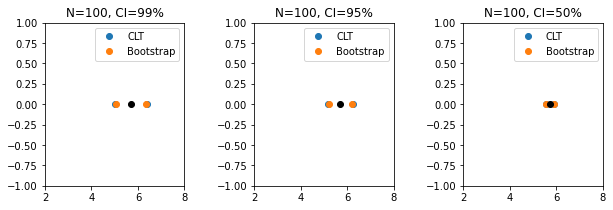

In [ ]:
# axis for plots
lowerB = 2
upperB = 8
boundY = 1

# sample sizes
#nN = [100, 200, 500]
#sizeN = len(nN)
sizeN = N

# confidence levels
alpha = np.array([0.01, 0.05, 0.5])
# compute quantiles
z = sp.stats.norm.ppf(1 - alpha/2)
sizeM = len(alpha)

# number of bootstrap samples
B = 100
V_B = np.zeros(B)

lb_clt  = np.zeros(sizeM)
ub_clt  = np.zeros(sizeM)
lb_boot = np.zeros(sizeM)
ub_boot = np.zeros(sizeM)

theta_hat = np.mean(X)
sig2_N = np.var(X, ddof=1)

# bootstrap
for b in range(B):
    X_b = np.random.choice(X, len(X), replace=True)
    theta_b = np.mean(X_b)
    V_B[b] = (theta_b - theta_hat)**2
mse_F = np.mean(V_B)


# clt confidence intervals
lb_clt = theta_hat - z * np.sqrt(sig2_N / N)
ub_clt = theta_hat + z * np.sqrt(sig2_N / N)

# bootstrap confidence intervals
lb_boot = theta_hat - z * np.sqrt(mse_F)
ub_boot = theta_hat + z * np.sqrt(mse_F)

fig = plt.figure(figsize=(10,3))
fig.subplots_adjust(hspace = .5, wspace = .5)
for j in range(sizeM):
    plt.subplot(1, sizeM, j + 1)
    plt.plot([lb_clt[j], ub_clt[j]], [0.0, 0.0], 'o', label='CLT')
    plt.plot([lb_boot[j], ub_boot[j]], [-0.0, -0.0], 'o', label='Bootstrap')
    plt.plot(theta_hat, 0, 'o', color='black')
    plt.title('N=%i, CI=%2.0f%s' % (N, 100*(1-alpha[j]), '%'))
    plt.xlim([lowerB, upperB])
    plt.ylim([-boundY, boundY])
    plt.legend(['CLT','Bootstrap'])
plt.show()


## Bootstrap MSE for variance and its CI

MSE for Variance 0.9689
[4.68378094 5.11677631 6.24064007]
[8.99871377 8.83763517 7.58884082]


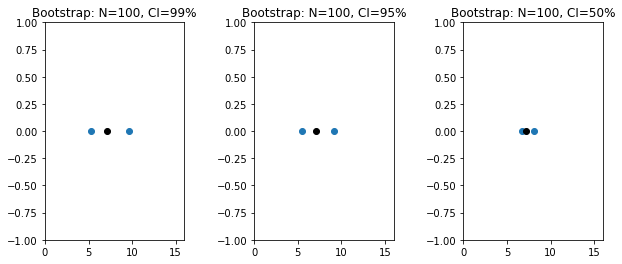

In [ ]:
# axis for plots
lowerB = 0
upperB = 16
boundY = 1

# confidence levels
alpha = np.array([0.01, 0.05, 0.5])
# compute quantiles
sizeM = len(alpha)

# number of bootstrap samples
B = 200
theta_b = np.zeros(B)
V_B = np.zeros(B)

lb_boot = np.zeros([1, sizeM])
ub_boot = np.zeros([1, sizeM])

sig2_N = np.var(X, ddof=1)

# bootstrap
for b in range(B):
    X_b = np.random.choice(X, len(X), replace=True)
    theta_b[b] = np.var(X_b)
    V_B[b] = (theta_b[b] - sig2_N)**2
mse_F_var = np.mean(V_B)

print('MSE for Variance %2.4f' %mse_F_var)

# Compute Confidence Interval
lower_b = np.percentile(theta_b, 100 * (alpha/2))
upper_b = np.percentile(theta_b, 100 * (1 - alpha/2))

print(lower_b)
print(upper_b)

fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace = .5, wspace = .5)
for j in range(sizeM):
    plt.subplot(1, sizeM, j + 1)
    # following the lecture notes
    plt.plot([2*sig2_N-upper_b[j], 2*sig2_N-lower_b[j]], [0,0], 'o')
    plt.plot(sig2_N, 0, 'o', color='black')
    plt.title('Bootstrap: N=%i, CI=%2.0f%s' % (N, 100*(1-alpha[j]), '%'))
    plt.xlim([lowerB, upperB])
    plt.ylim([-boundY, boundY])
plt.show()

In [ ]:
class caseBothUnknown(object):
    def __init__(self, ax1, ax2, mu=0, sig=1):
        # true parameters
        self.mu = mu
        self.sig = sig

        # set up plot parameters for mu
        self.x1 = np.linspace(-10, 10, 200)
        self.ax1 = ax1
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(0, 4)
        self.ax1.grid(True)
        self.ax1.set_xlabel('$\mu$')
        self.ax1.set_ylabel('$p(\mu \mid x)$')
        self.ax1.set_title('Case3: $\mu$ and $\sigma^2$ are unknown')
        self.ax1.axvline(self.mu, linestyle='--', color='red')

        # set up plot parameters for sigma^2
        self.x2 = np.linspace(0.002, 0.5, 200)
        self.ax2 = ax2
        self.ax2.set_xlim(0, 0.5)
        self.ax2.set_ylim(0, 30)
        self.ax2.grid(True)
        self.ax2.set_xlabel('$1/\sigma^2$')
        self.ax2.set_ylabel('$p(1/\sigma^2 \mid x)$')
        self.ax2.axvline(1./self.sig**2, linestyle='--', color='red')
        # lines
        self.line1, = ax1.plot([], [], 'g-')
        self.line2, = ax2.plot([], [], 'g-')

    def init(self):
        # hyperparameters (initial guess)
        self.a0 = 0.2
        self.b0 = 0.5
        self.mu0 = 0.5
        self.k0 = 1. # precision k=1/sigma**2
        # line
        t1 = (self.x1 - self.mu0)/np.sqrt(self.b0/(self.a0*self.k0)) # marginal is t
        self.line1.set_data(self.x1, t.pdf(t1, df=2*self.a0)/np.sqrt(self.b0/(self.a0*self.k0)))
        self.line2.set_data(self.x2, gamma.pdf(self.x2, self.a0, scale=1./self.b0))
        return 0

    def __call__(self, i):
        if i == 0:
            return self.init()
        # simulate a normal rv and update the hyperparameters
        z = self.mu + self.sig * np.random.randn()
        # posterior
        mu_new = (self.k0*self.mu0 + z)/(self.k0 + 1)
        k_new = self.k0 + 1
        a_new = self.a0 + 0.5
        b_new = self.b0 + (self.k0/(self.k0 + 1))*(z - self.mu0)**2/2
        # marginal for mu is t
        t1 = (self.x1 - mu_new)/np.sqrt(b_new/(a_new*k_new))
        y1 = t.pdf(t1, df=2*a_new)/np.sqrt(b_new/(a_new*k_new))
        y2 = gamma.pdf(self.x2, a_new, scale=1./b_new)
        # update prior by using posterior as a prior
        self.mu0 = mu_new
        self.k0 = k_new
        self.a0 = a_new
        self.b0 = b_new
        self.line1.set_data(self.x1, y1)
        self.line2.set_data(self.x2, y2)
        return 0

<IPython.core.display.Javascript object>


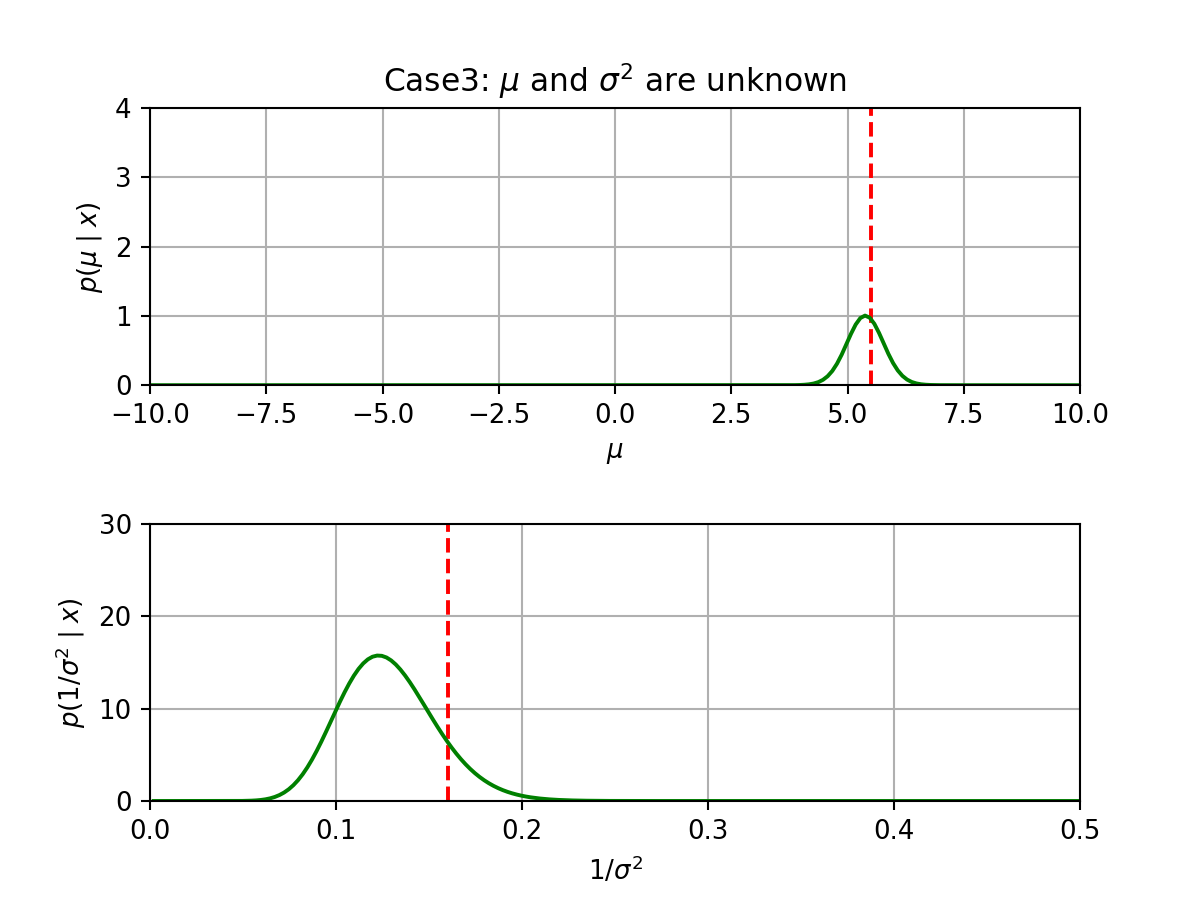

In [ ]:
num_obs = 50
# true params
mu = 5.5
sig = 2.5

# run simulation
# cannot use inline mode
%matplotlib notebook
cycle_anim = False # the animation only runs once
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5)
ud = caseBothUnknown(ax1, ax2, mu=mu, sig=sig)
anim = FuncAnimation(fig, ud, frames=np.arange(num_obs), init_func=ud.init, interval=25, blit=True, repeat=cycle_anim)